<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/week6/GRU-PyTorc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import string
from collections import Counter

In [10]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [11]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [12]:
# Load data
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json'
response = requests.get(url)

if response.status_code == 200:
    try:
        # Try to read as newline-delimited JSON
        df = pd.read_json(url, lines=True)
    except ValueError:
        # If that fails, try to read as a list of dictionaries
        data = json.loads(response.text)
        df = pd.DataFrame(data)
else:
    print("Failed to download data, check URL or internet connection.")

print("Data shape:", df.shape)
print("\nSample data:")
print(df.head())

Data shape: (26709, 3)

Sample data:
                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


In [13]:
# Data preprocessing
# Making sure we have the right columns
if 'headline' in df.columns and 'is_sarcastic' in df.columns:
    # Use only required columns
    df = df[['headline', 'is_sarcastic']]
    # Rename columns for clarity
    df.columns = ['text', 'label']
else:
    print("Column names might be different, please check the dataset structure")


In [14]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
text     0
label    0
dtype: int64


In [15]:
# Check class distribution
print("\nClass distribution:")
print(df['label'].value_counts())



Class distribution:
label
0    14985
1    11724
Name: count, dtype: int64


In [16]:
# Text cleaning function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into a string
    return ' '.join(tokens)

In [17]:
# Apply text cleaning
df['cleaned_text'] = df['text'].apply(clean_text)


In [18]:
# Build vocabulary
def build_vocab(texts, max_vocab_size=10000):
    word_counter = Counter()
    for text in texts:
        for word in text.split():
            word_counter[word] += 1

    # Add special tokens
    vocab = {'<PAD>': 0, '<UNK>': 1}

    # Add most common words
    for word, _ in word_counter.most_common(max_vocab_size - len(vocab)):
        vocab[word] = len(vocab)

    return vocab

In [19]:
# Create vocabulary
vocab = build_vocab(df['cleaned_text'])
print(f"\nVocabulary size: {len(vocab)}")



Vocabulary size: 10000


In [20]:
# Convert text to index sequence
def text_to_sequence(text, vocab):
    return [vocab.get(word, vocab['<UNK>']) for word in text.split()]

df['sequence'] = df['cleaned_text'].apply(lambda x: text_to_sequence(x, vocab))


In [21]:
# Find maximum sequence length and statistics
seq_lengths = [len(seq) for seq in df['sequence']]
max_seq_len = max(seq_lengths)
avg_seq_len = sum(seq_lengths) / len(seq_lengths)

print(f"\nMaximum sequence length: {max_seq_len}")
print(f"Average sequence length: {avg_seq_len}")



Maximum sequence length: 26
Average sequence length: 6.9848740125051485


In [22]:
# We'll use a reasonable max length for padding
max_len = min(int(avg_seq_len * 1.5), max_seq_len)
print(f"Using max sequence length for padding: {max_len}")


Using max sequence length for padding: 10


In [23]:
# Create PyTorch dataset
class SarcasmDataset(Dataset):
    def __init__(self, sequences, labels, max_len):
        self.sequences = sequences
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        # Truncate or pad sequence
        if len(seq) > self.max_len:
            seq = seq[:self.max_len]
        else:
            seq = seq + [0] * (self.max_len - len(seq))

        return torch.tensor(seq, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)


In [24]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df['sequence'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

In [25]:
# Create datasets
train_dataset = SarcasmDataset(X_train, y_train, max_len)
test_dataset = SarcasmDataset(X_test, y_test, max_len)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [26]:
# Define GRU model
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=True,
                           dropout=dropout if n_layers > 1 else 0,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text shape: [batch size, sequence length]
        embedded = self.dropout(self.embedding(text))
        # embedded shape: [batch size, sequence length, embedding dim]

        output, hidden = self.gru(embedded)
        # output shape: [batch size, sequence length, hidden dim * 2]
        # hidden shape: [n layers * 2, batch size, hidden dim]

        # Concatenate the final forward and backward hidden states
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        # hidden shape: [batch size, hidden dim * 2]

        hidden = self.dropout(hidden)
        return self.fc(hidden).squeeze(1)


In [27]:
# Model hyperparameters
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.5

# Initialize model
model = GRUModel(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
model = model.to(device)


In [28]:
# Print model architecture
print("\nModel Architecture:")
print(model)



Model Architecture:
GRUModel(
  (embedding): Embedding(10000, 300, padding_idx=0)
  (gru): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [29]:
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()


In [30]:
# Training function
def train(model, dataloader, optimizer, criterion):
    model.train()

    epoch_loss = 0
    all_preds = []
    all_labels = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(inputs)

        # Calculate loss
        loss = criterion(predictions, labels)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

        # Store predictions and labels for metrics
        preds = torch.sigmoid(predictions) >= 0.5
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return epoch_loss / len(dataloader), accuracy, precision, recall, f1


In [31]:
# Evaluation function
def evaluate(model, dataloader, criterion):
    model.eval()

    epoch_loss = 0
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            predictions = model(inputs)

            # Calculate loss
            loss = criterion(predictions, labels)

            # Accumulate loss
            epoch_loss += loss.item()

            # Store predictions and labels for metrics
            probs = torch.sigmoid(predictions)
            preds = probs >= 0.5
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    # Calculate ROC and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return epoch_loss / len(dataloader), accuracy, precision, recall, f1, roc_auc, fpr, tpr, cm


In [32]:
# Training loop
n_epochs = 10
best_val_acc = 0
train_losses = []
val_losses = []
train_accs = []
val_accs = []

print("\nStarting training...")
for epoch in range(n_epochs):
    # Train model
    train_loss, train_acc, train_prec, train_rec, train_f1 = train(model, train_loader, optimizer, criterion)

    # Evaluate model
    val_loss, val_acc, val_prec, val_rec, val_f1, val_auc, fpr, tpr, cm = evaluate(model, test_loader, criterion)

    # Store metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Print progress
    print(f"Epoch {epoch+1}/{n_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, F1: {train_f1:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")

    # Check if this is the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_gru_model.pt')
        print("  Saved new best model!")

    # Early stopping if both train and test accuracy are above 80%
    if train_acc >= 0.8 and val_acc >= 0.8:
        print("\nEarly stopping! Both train and test accuracy are above 80%")
        break


Starting training...
Epoch 1/10
  Train Loss: 0.6108, Accuracy: 0.6590, Precision: 0.6409, Recall: 0.5072, F1: 0.5663
  Val Loss: 0.5308, Accuracy: 0.7310, Precision: 0.7888, Recall: 0.5288, F1: 0.6331, AUC: 0.8105
  Saved new best model!
Epoch 2/10
  Train Loss: 0.5167, Accuracy: 0.7420, Precision: 0.7279, Recall: 0.6582, F1: 0.6913
  Val Loss: 0.4733, Accuracy: 0.7714, Precision: 0.7266, Recall: 0.7684, F1: 0.7469, AUC: 0.8522
  Saved new best model!
Epoch 3/10
  Train Loss: 0.4489, Accuracy: 0.7864, Precision: 0.7691, Recall: 0.7336, F1: 0.7509
  Val Loss: 0.4576, Accuracy: 0.7853, Precision: 0.7939, Recall: 0.6900, F1: 0.7383, AUC: 0.8726
  Saved new best model!
Epoch 4/10
  Train Loss: 0.4022, Accuracy: 0.8150, Precision: 0.8043, Recall: 0.7647, F1: 0.7840
  Val Loss: 0.4380, Accuracy: 0.7948, Precision: 0.7964, Recall: 0.7156, F1: 0.7538, AUC: 0.8801
  Saved new best model!
Epoch 5/10
  Train Loss: 0.3538, Accuracy: 0.8434, Precision: 0.8302, Recall: 0.8085, F1: 0.8192
  Val Los

In [33]:
# Load best model
model.load_state_dict(torch.load('best_gru_model.pt'))


<All keys matched successfully>

In [34]:
# Final evaluation
final_loss, final_acc, final_prec, final_rec, final_f1, final_auc, fpr, tpr, cm = evaluate(model, test_loader, criterion)

print("\nFinal Model Performance:")
print(f"  Accuracy: {final_acc:.4f}")
print(f"  Precision: {final_prec:.4f}")
print(f"  Recall: {final_rec:.4f}")
print(f"  F1 Score: {final_f1:.4f}")
print(f"  AUC-ROC: {final_auc:.4f}")



Final Model Performance:
  Accuracy: 0.8068
  Precision: 0.8122
  Recall: 0.7284
  F1 Score: 0.7680
  AUC-ROC: 0.8907


In [35]:
# Visualize training history
plt.figure(figsize=(12, 5))


<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

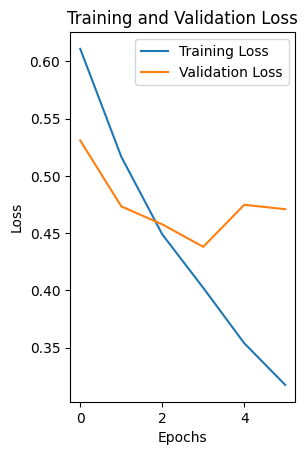

In [36]:
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

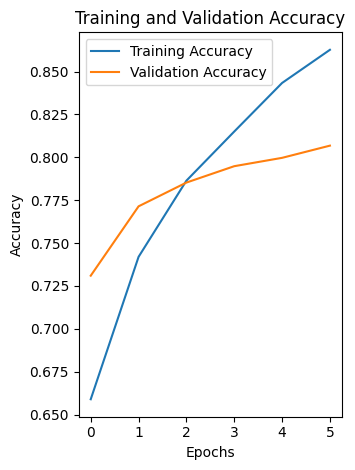

In [37]:
# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()


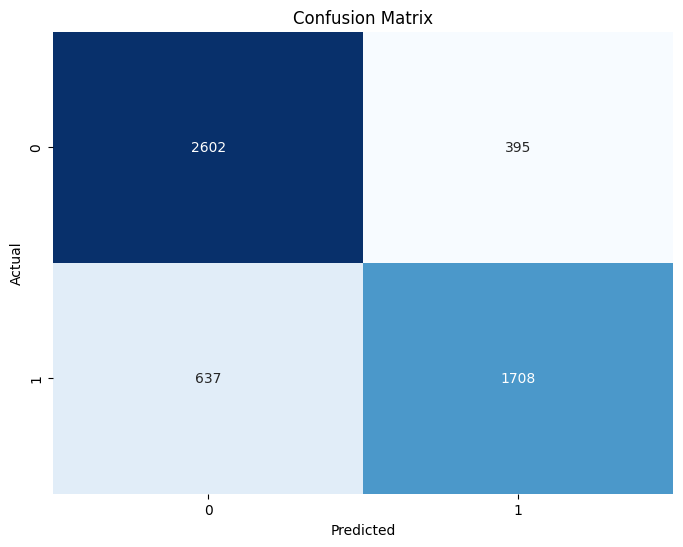

In [38]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')
plt.show()

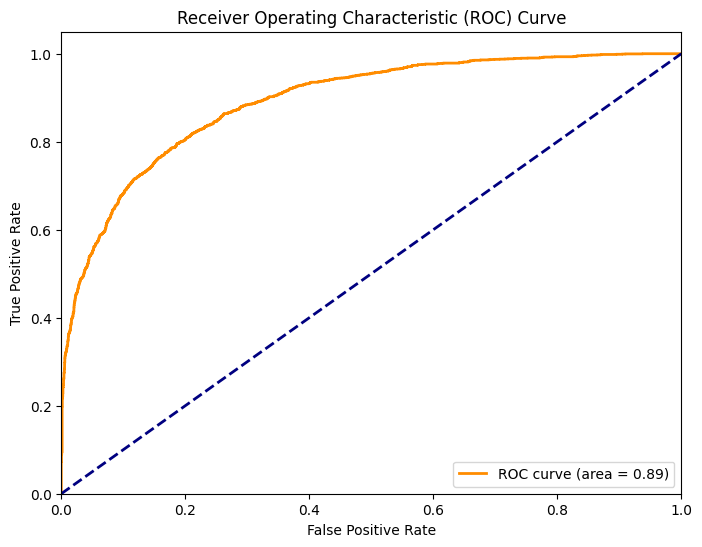

In [39]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {final_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()


In [40]:
# Test model with sample text
def predict_sarcasm(text, model, vocab, max_len):
    # Clean text
    cleaned_text = clean_text(text)

    # Convert to sequence
    sequence = text_to_sequence(cleaned_text, vocab)

    # Pad sequence
    if len(sequence) > max_len:
        sequence = sequence[:max_len]
    else:
        sequence = sequence + [0] * (max_len - len(sequence))

    # Convert to tensor
    tensor = torch.tensor(sequence, dtype=torch.long).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        prediction = torch.sigmoid(model(tensor)).item()

    return prediction

In [41]:
# Test with some examples
test_examples = [
    "wow, what a great day!",
    "I just love waiting in line for hours.",
    "This is the best product ever made!",
    "I can't believe how amazing it is to wake up at 5am for work."
]

print("\nTesting model with examples:")
for text in test_examples:
    prediction = predict_sarcasm(text, model, vocab, max_len)
    print(f'Text: "{text}"')
    print(f'Prediction: {"Sarcastic" if prediction >= 0.5 else "Not Sarcastic"} (Confidence: {prediction:.4f})\n')


Testing model with examples:
Text: "wow, what a great day!"
Prediction: Not Sarcastic (Confidence: 0.0398)

Text: "I just love waiting in line for hours."
Prediction: Not Sarcastic (Confidence: 0.4095)

Text: "This is the best product ever made!"
Prediction: Not Sarcastic (Confidence: 0.0083)

Text: "I can't believe how amazing it is to wake up at 5am for work."
Prediction: Not Sarcastic (Confidence: 0.3559)

